In [ ]:
"""
 - no merging APs - separate APs work better 
 - Average works best (99% 1 step + 2 steps, pixel) (98% 1 step + 2 steps, redmi)
 - weighting by power used / total power received doesn't work 
 - KS doesnt work 
 - Average > Median > Max 
 - random direction = disaster 
 - sometimes RSSI data from an AP is missing (not received) -> misclassification
"""

In [5]:
from utils import *
import sys, os, random
# from compare_locations import compare_locations

datadir = "./data/nowl/"
# preprocessed already, with 


In [6]:
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json",
"1-pixel-25-02-2021_21-16-46.json",
"2-pixel-25-02-2021_16-27-45.json",
"3-pixel-04-03-2021_16-18-50.json",
"4-pixel-04-03-2021_16-43-50.json",
"5-pixel-04-03-2021_17-11-32.json",
"6-pixel-17-03-2021_12-52-29.json",
"7-pixel-17-03-2021_13-14-36.json"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json",
"1-redmi-25-02-2021_21-16-10.json",
"2-redmi-25-02-2021_16-27-08.json",
"3-redmi-04-03-2021_16-18-52.json",
"4-redmi-04-03-2021_16-43-45.json",
"5-redmi-04-03-2021_17-11-30.json",
"6-redmi-17-03-2021_12-52-29.json",
"7-redmi-17-03-2021_13-14-39.json"]


retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    petaje.append(etaj)
    

In [61]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 

def merge_wifi_fingerprints(flist):
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
                #fingerprint["wifi"][mac]['rssi'] = []
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint


def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = False):
    rssi1 = []
    rssi2 = []
    w = [] #weight for braycurtis
    
    # take the first fingerprint in the list 
    #wifi1 = c1['fingerprints'][0]['wifi']
    #wifi2 = c2['fingerprints'][0]['wifi']

    # take a random fingerprint in the list 
    #wifi1 = c1['fingerprints'][random.randint(0,3)]['wifi']
    #wifi2 = c2['fingerprints'][random.randint(0,3)]['wifi']

    # first & third - as if measuring twice at 180 degrees
    #wifi1 = merge_wifi_fingerprints([c1['fingerprints'][0], c1['fingerprints'][2]])['wifi']
    #wifi2 = merge_wifi_fingerprints([c2['fingerprints'][0], c2['fingerprints'][2]])['wifi']
    
    #merge all existing fingerprints for each collection
    wifi1 = merge_wifi_fingerprints(c1['fingerprints'])['wifi']
    wifi2 = merge_wifi_fingerprints(c2['fingerprints'])['wifi']
    
    # all power received by the query
    power1 = 0
    for ap in wifi1:
        power1 += np.sum(adjust_rssi(wifi1[ap]['rssi']))
        
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    #print("common aps=", len(common_aps))
    
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1

    # TODO: find the best metric
    # If not enough common APs -> similarity = 1
    if len(common_aps) * 10 < len(wifi1.keys()) or len(common_aps) < 3:
        return 1

    for ap in common_aps:
        
        if selection == 'Bestdir':
            for f1 in c1['fingerprints']: # all fingerprint dirs in the query 
                if not ap in f1['wifi'].keys():
                    continue
                m1 = np.average(adjust_rssi(f1['wifi'][ap]['rssi']))
                best = 100                
                for f2 in c2['fingerprints']: 
                    if not ap in f2['wifi'].keys():
                        continue
                    m2 = np.average(adjust_rssi(f2['wifi'][ap]['rssi']))
                    if(math.fabs(m2-m1)) < best:  # find one dir with closest RSSI
                        best = math.fabs(m2-m1)
                        bestf = m2
                rssi1.append(m1)
                rssi2.append(bestf)
                
        # Take only the first RSSI value                
        if selection == 'First':
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
        if selection == 'Average':
            rssi1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
            w.append(min(len(wifi1[ap]['rssi']), len(wifi2[ap]['rssi'])))

        if selection == 'Median':
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Mean':
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Std':
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Max':
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
        if selection == 'KS':
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

        if selection == 'Tempered':
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))
            
    rssi11 = []
    rssi22 = []
    if selection != 'KS':
        
        if (dif == True):
            #print(rssi1)
            rssi11.append(np.diff(rssi1))
            rssi22.append(np.diff(rssi2))
            rssi1 = rssi11
            rssi2 = rssi22        

    #print(f"1={rssi1}\n2={rssi2}\ncommon={common_aps}")
    #if selection != 'KS':
    #    rssi1 = list(map(lambda x: x - np.mean(rssi1), rssi1))
    #    rssi2 = list(map(lambda x: x - np.mean(rssi2), rssi2))
    return simil_method(tuple(rssi1), tuple(rssi2))
#        return simil_method(tuple(rssi1), tuple(rssi2))*sum(rssi1)/power1
# weigh final result with used power/total power   

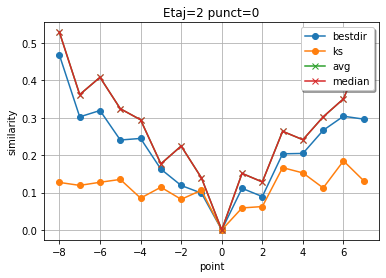

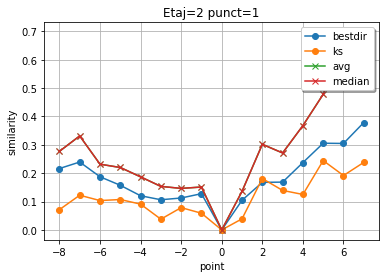

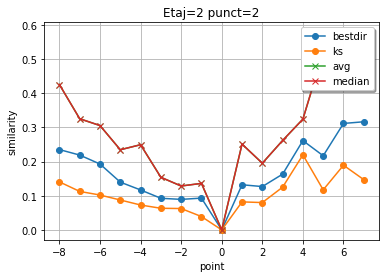

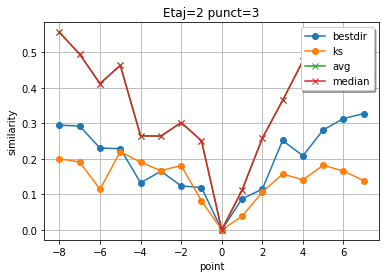

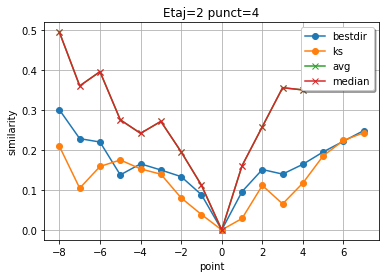

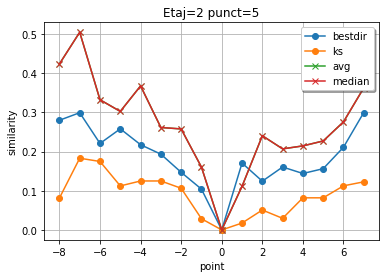

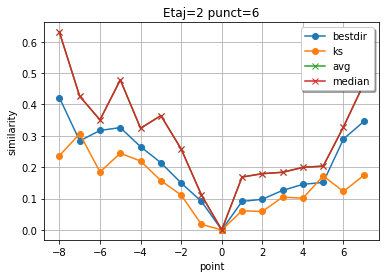

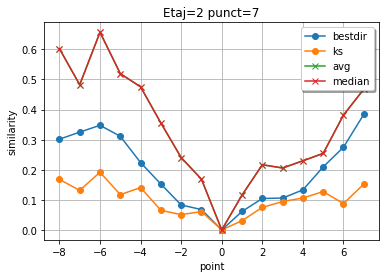

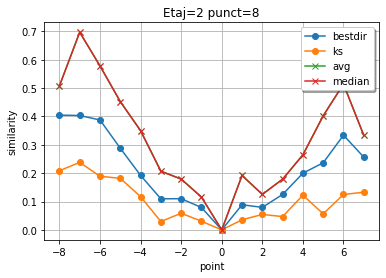

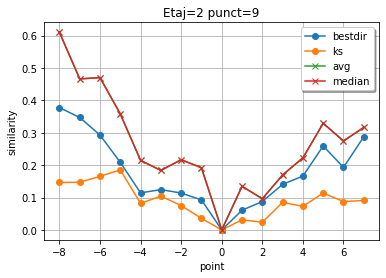

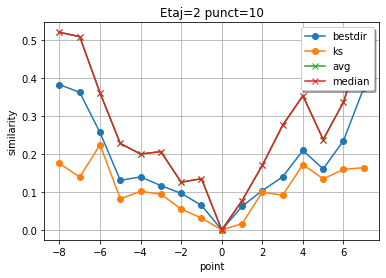

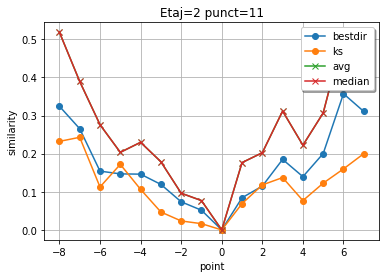

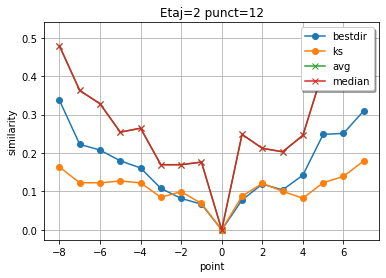

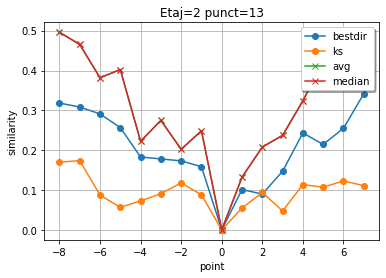

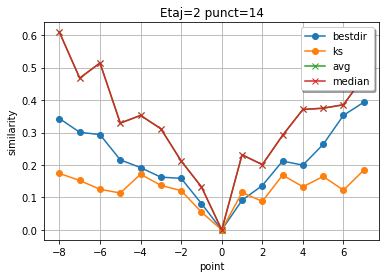

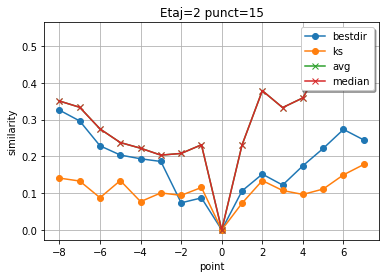

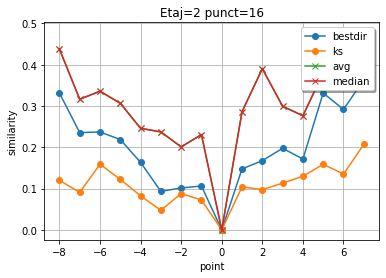

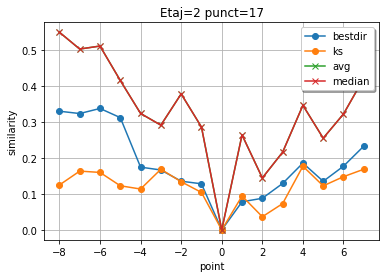

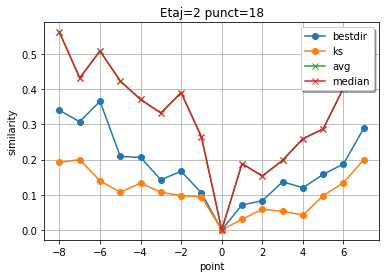

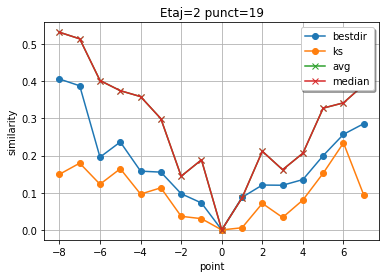

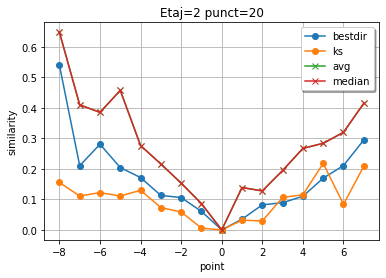

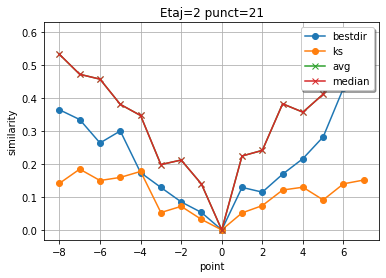

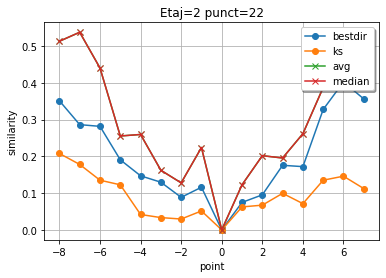

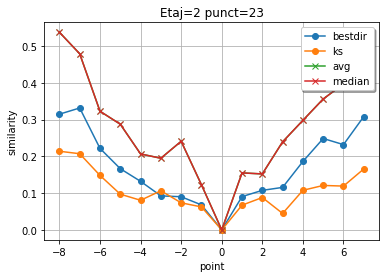

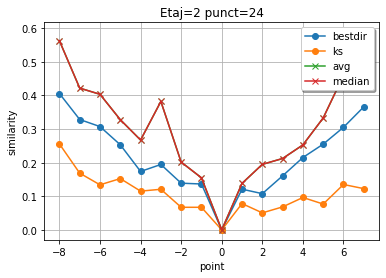

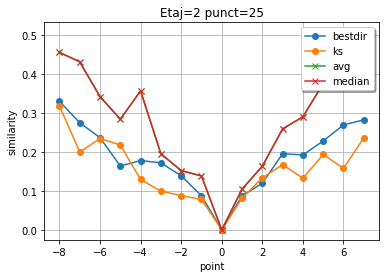

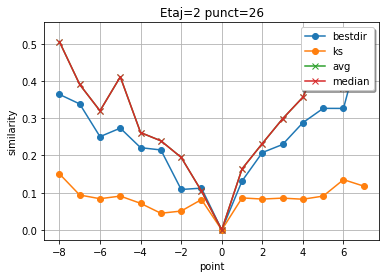

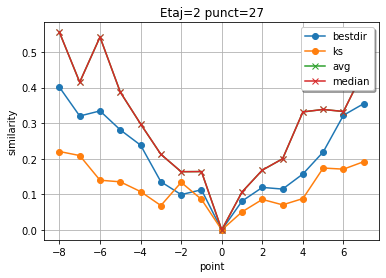

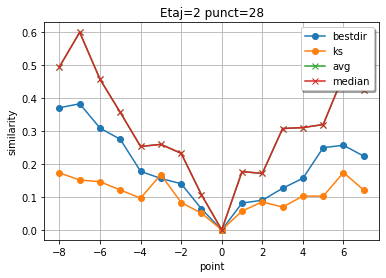

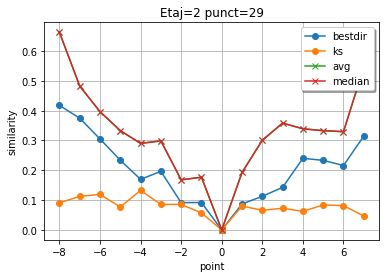

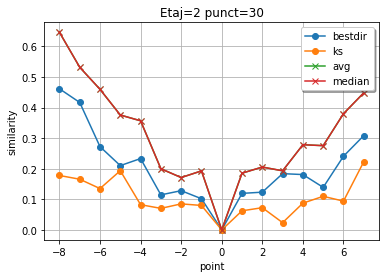

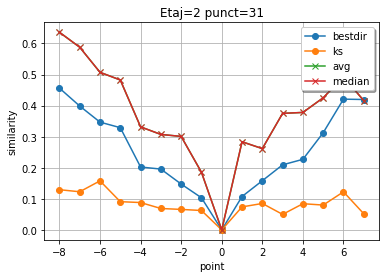

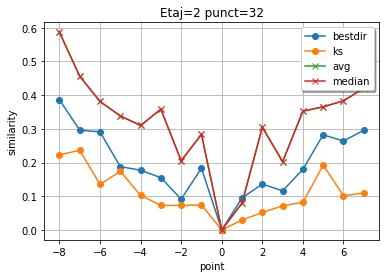

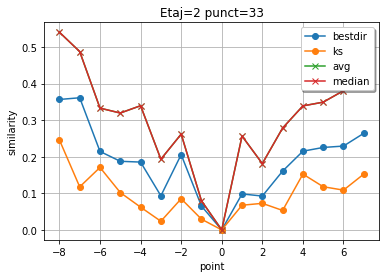

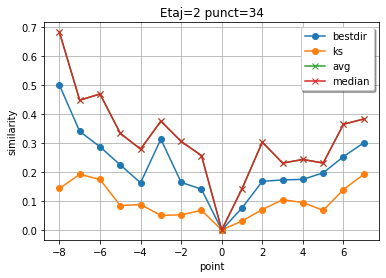

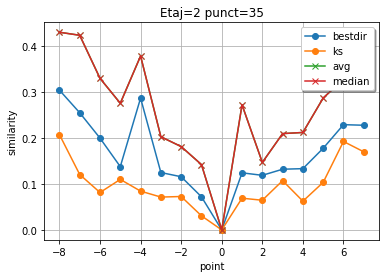

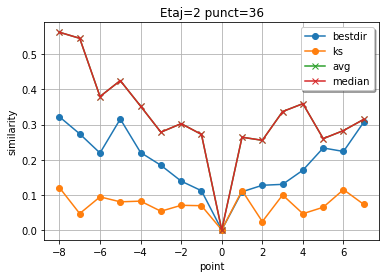

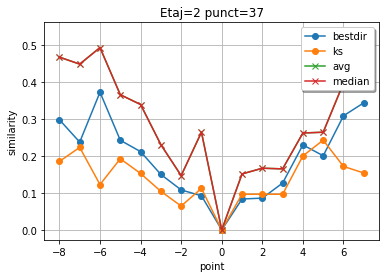

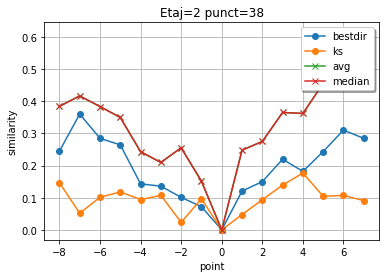

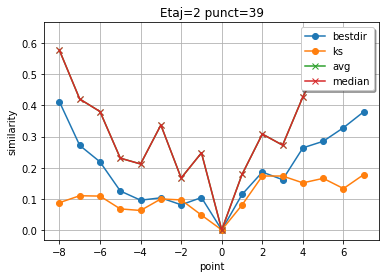

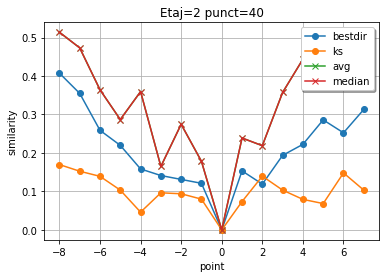

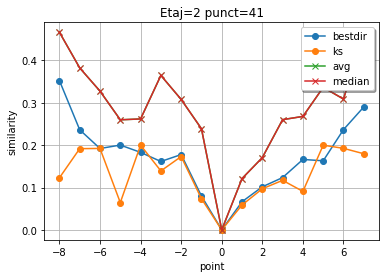

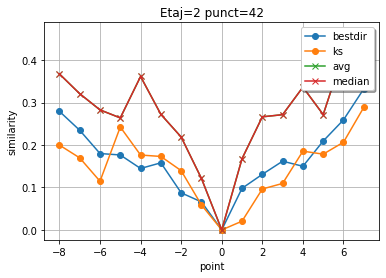

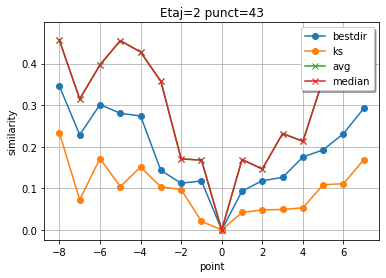

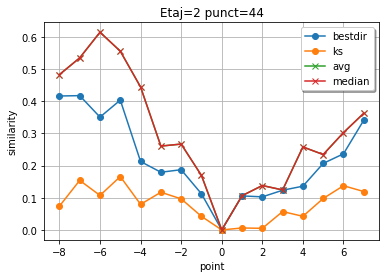

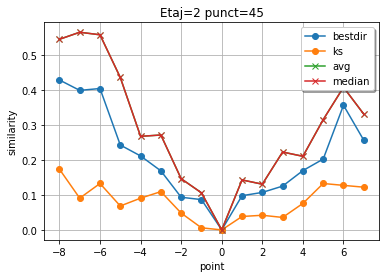

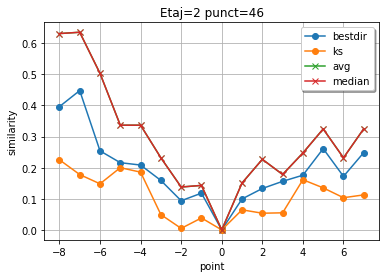

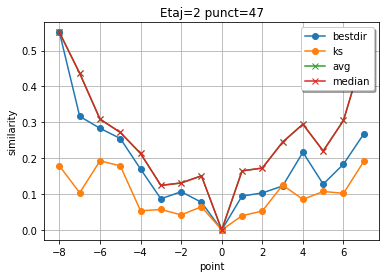

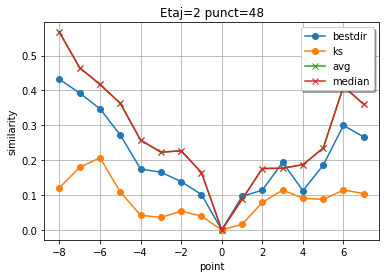

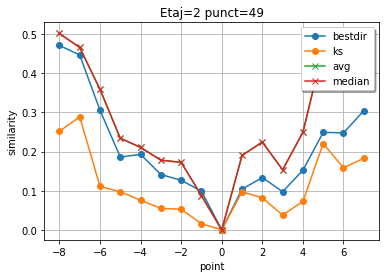

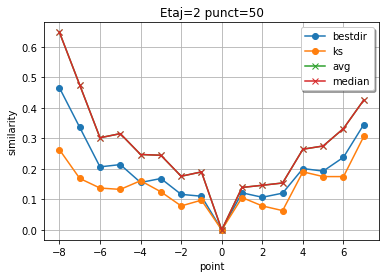

In [4]:
# visualize points on a floor in relation to their neighbors 
#
etaje = retaje
etaj = 2
npct = len(etaje[etaj])
r = np.arange(0, npct)
for point in r: 
    mx = np.array([])
    ks = np.array([])
    avg = np.array([])
    md = np.array([])
    ra = (np.arange(point-8, point+8) + npct)%npct
    for p in ra:
        mx = np.append(mx, compare_locations(etaje[etaj][point], etaje[etaj][p], selection = 'Bestdir'))
        ks = np.append(ks, compare_locations(etaje[etaj][point], etaje[etaj][p], selection = 'KS'))
        avg = np.append(avg, compare_locations(etaje[etaj][point], etaje[etaj][p], selection = 'Average'))
        md = np.append(md, compare_locations(etaje[etaj][point], etaje[etaj][p], selection = 'Median'))

    plt.plot(np.arange(0, len(ra))-8, mx, "o-", label='bestdir')
    plt.plot(np.arange(0, len(ra))-8, ks, "o-", label='ks')    
    plt.plot(np.arange(0, len(ra))-8, avg, "x-", label='avg')    
    plt.plot(np.arange(0, len(ra))-8, md, "x-", label='median')    
    plt.xlabel('point')
    plt.ylabel('similarity')
    plt.grid(True)
    plt.title(f"Etaj={etaj} punct={point}")
    plt.legend(loc="upper right",shadow=True, fancybox=True)
    plt.show()


In [2]:
# Generate a matrix (list of lists) for a collection (etaj)
# [point_index, index_of_closest_pt, dist_to_closest_pt, index_diff, dist_2_best_neighbor]
def test_allvsall(collection, selection='Average', dif = False):
    lc = len(collection)
    #arr = [[0]*lc]*lc - nu merge!
    arr = [[0 for i in range(lc)] for j in range(lc)]
    for l in range(0, lc):
        for c in range(0, l):
            arr[l][c] = compare_locations(collection[l], collection[c], braycurtis, selection, dif)
            arr[c][l] = arr[l][c]
        arr[l][l] = 1 # max 

   # print("#pt minpt mindist diff dist2nbr")
    listp = []
    for l in range(0, lc):
        mindist = min(arr[l])
        index_of_min = arr[l].index(mindist)
        diff = diff_modulo(l, arr[l].index(mindist), lc)
        distl=arr[l][(l-1+lc)%lc]
        distr=arr[l][(l+1)%lc]

        #print(l, index_of_min, mindist, diff, min(distl, distr))
        listp.append([l, index_of_min, mindist, diff, min(distl, distr)])
    return listp



def test_queryvsall(query, collections, selection='Average', dif = False):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1.0 
    mini = -1; 
    for c in range(0, len(collections)):
        d = compare_locations(query, collections[c], braycurtis, selection, dif)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  
    

In [62]:
#  query = Pixel  
#  DB = redmi 
cl_sim = []
cl_steps = []
cl_dist = []

cl_sim_dif = []
cl_steps_dif = []
cl_dist_dif = []

for e in range(0, len(retaje)):
#for e in range(0, len(petaje)): 
    for p in range(0, len(petaje[e])):
        sim, index, d =  test_queryvsall(petaje[e][p], retaje[e], 'Average', dif = False)
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)
        
        sim_dif, index_dif, d_dif =  test_queryvsall(petaje[e][p], retaje[e], 'Average', dif = True)
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim_dif.append(sim_dif)
        cl_steps_dif.append(diff_modulo(p, index_dif, len(petaje[e])))
        cl_dist_dif.append(d_dif)
   

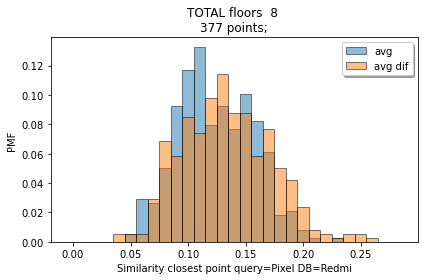

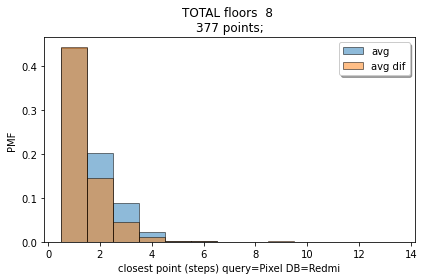

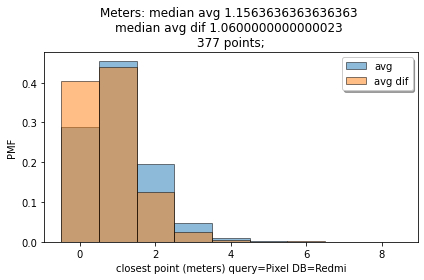

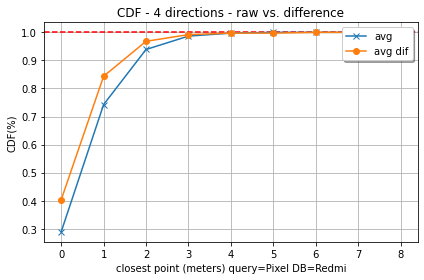

In [63]:

b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
hist_sim_dif, bins_out_dif = np.histogram(np.array(cl_sim_dif), b, density=False)
hist_sim_dif = hist_sim_dif / len(cl_sim_dif)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.5, label='avg')
plt.bar(b[:-1], hist_sim_dif, width=bin_width, ec='k', alpha=0.5, label='avg dif')
plt.xlabel("Similarity closest point query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(retaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

b = np.arange(1, 15, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_steps), b, density=False)
hist_sim = hist_sim / len(cl_sim)
hist_sim_dif, bins_out_dif = np.histogram(np.array(cl_steps_dif), b, density=False)
hist_sim_dif = hist_sim_dif / len(cl_sim_dif)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.5, label='avg')
plt.bar(b[:-1], hist_sim_dif, width=bin_width, ec='k', alpha=0.5, label='avg dif')
plt.xlabel("closest point (steps) query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(retaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)



b = np.arange(0, 10, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
hist_sim_dif, bins_out_dif = np.histogram(np.array(cl_dist_dif), b, density=False)
hist_sim_dif = hist_sim_dif / len(cl_sim_dif)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.5, label='avg')
plt.bar(b[:-1], hist_sim_dif, width=bin_width, ec='k', alpha=0.5, label='avg dif')
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{} {} \n{}{}".format("Meters: median avg", np.median(cl_dist), "median avg dif", np.median(cl_dist_dif), len(cl_sim), " points;"))
plt.tight_layout()
plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)




cdf=np.cumsum(hist_sim)
cdf_dif=np.cumsum(hist_sim_dif)
fig = plt.figure()
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("CDF(%)")
plt.title("{}".format("CDF - 4 directions - raw vs. difference"))
plt.plot(b[:-1], cdf, "x-", label='avg')
plt.plot(b[:-1], cdf_dif, "o-", label='avg dif')
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
fig.savefig("4directionsCDF.pdf", bbox_inches='tight')



In [254]:
#  query = Redmi  
#  DB = Pixel
cl_sim = []
cl_steps = []
cl_dist = []

#for e in len(retaje):
for e in range(0, len(retaje)): 
    for p in range(0, len(retaje[e])):
        sim, index, d =  test_queryvsall(retaje[e][p], petaje[e], 'Average')
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)


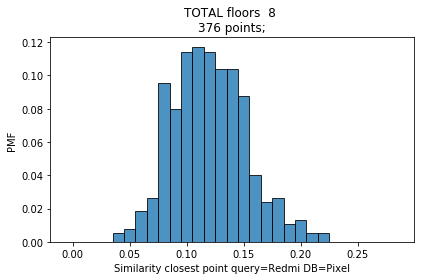

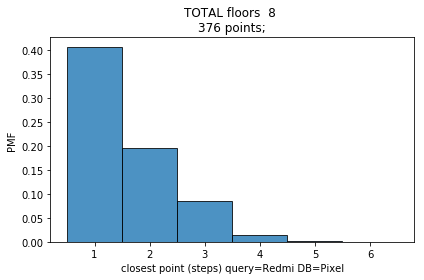

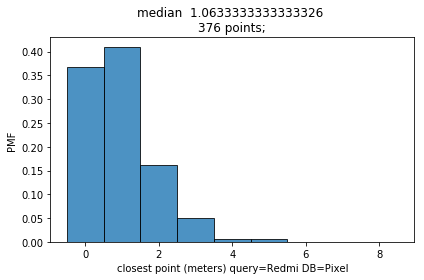

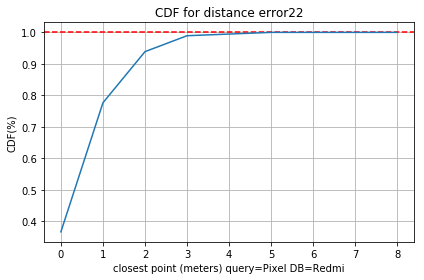

In [9]:

b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Similarity closest point query=Redmi DB=Pixel")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(petaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

b = np.arange(1, 8, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_steps), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (steps) query=Redmi DB=Pixel")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(petaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)



b = np.arange(0, 10, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters) query=Redmi DB=Pixel")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("median ", np.median(cl_dist), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

cdf=np.cumsum(hist_sim)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("CDF(%)")
plt.title("{}{}".format("CDF for distance error", 22))
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.tight_layout()
plt.show()



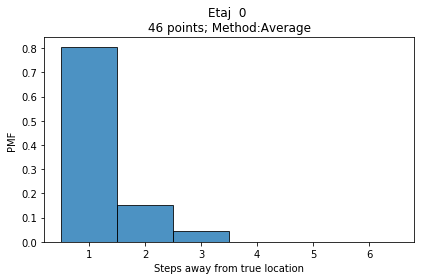

Percentages:  [0.80434783 0.15217391 0.04347826 0.         0.         0.        ]


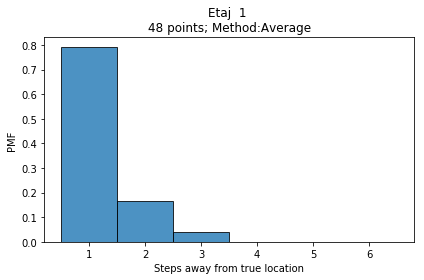

Percentages:  [0.79166667 0.16666667 0.04166667 0.         0.         0.        ]


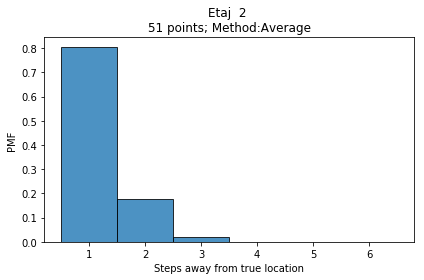

Percentages:  [0.80392157 0.17647059 0.01960784 0.         0.         0.        ]


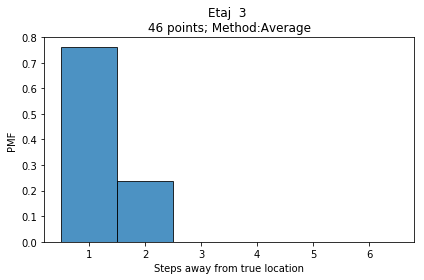

Percentages:  [0.76086957 0.23913043 0.         0.         0.         0.        ]


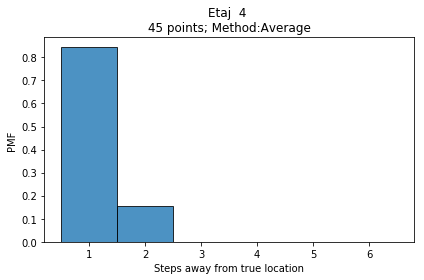

Percentages:  [0.84444444 0.15555556 0.         0.         0.         0.        ]


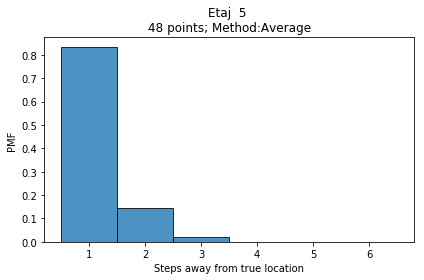

Percentages:  [0.83333333 0.14583333 0.02083333 0.         0.         0.        ]


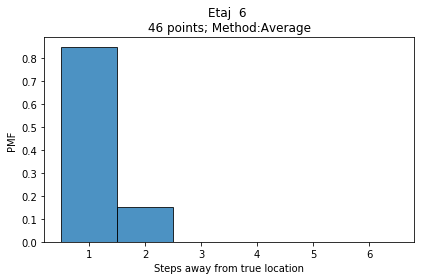

Percentages:  [0.84782609 0.15217391 0.         0.         0.         0.        ]


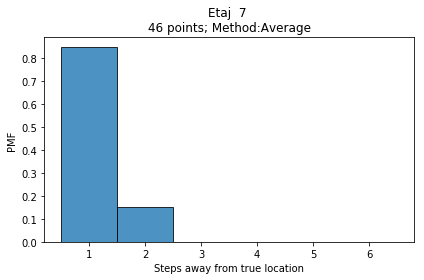

Percentages:  [0.84782609 0.15217391 0.         0.         0.         0.        ]


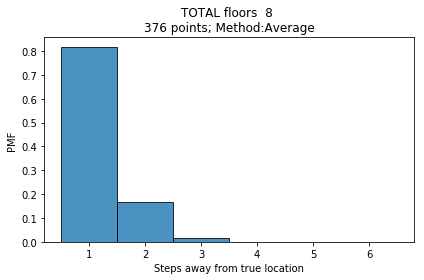

Percentages:  [0.81648936 0.16755319 0.01595745 0.         0.         0.        ]


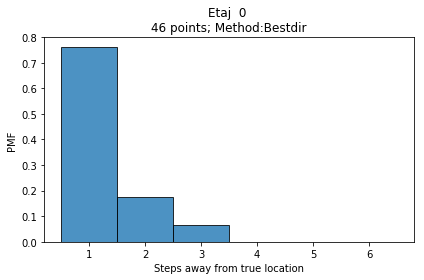

Percentages:  [0.76086957 0.17391304 0.06521739 0.         0.         0.        ]


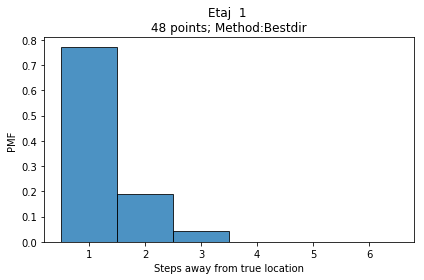

Percentages:  [0.77083333 0.1875     0.04166667 0.         0.         0.        ]


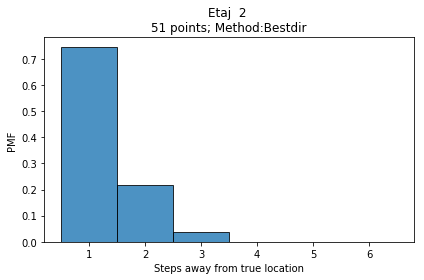

Percentages:  [0.74509804 0.21568627 0.03921569 0.         0.         0.        ]


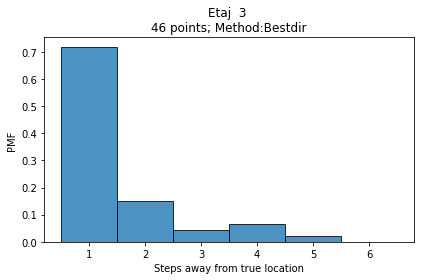

Percentages:  [0.7173913  0.15217391 0.04347826 0.06521739 0.02173913 0.        ]


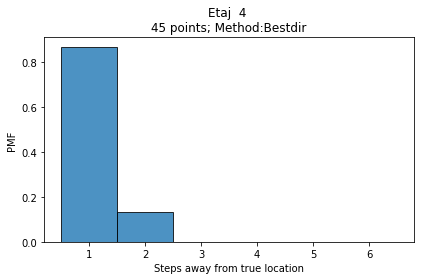

Percentages:  [0.86666667 0.13333333 0.         0.         0.         0.        ]


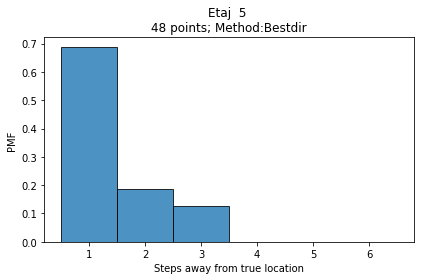

Percentages:  [0.6875 0.1875 0.125  0.     0.     0.    ]


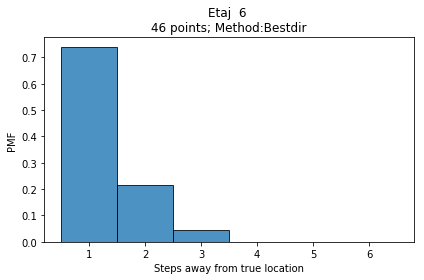

Percentages:  [0.73913043 0.2173913  0.04347826 0.         0.         0.        ]


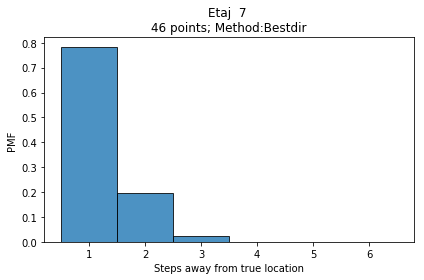

Percentages:  [0.7826087  0.19565217 0.02173913 0.         0.         0.        ]


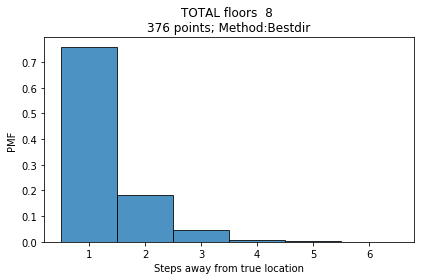

Percentages:  [0.75797872 0.18351064 0.04787234 0.00797872 0.00265957 0.        ]


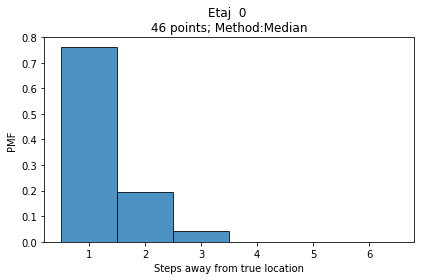

Percentages:  [0.76086957 0.19565217 0.04347826 0.         0.         0.        ]


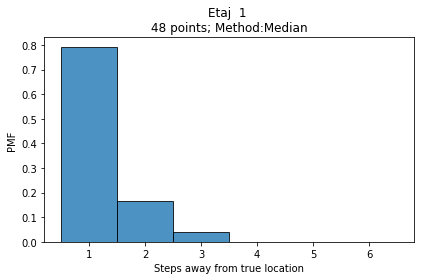

Percentages:  [0.79166667 0.16666667 0.04166667 0.         0.         0.        ]


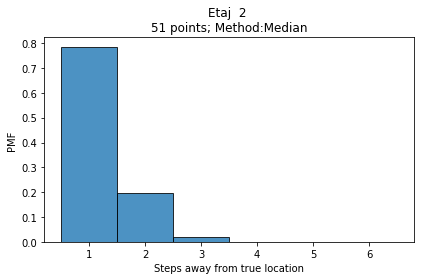

Percentages:  [0.78431373 0.19607843 0.01960784 0.         0.         0.        ]


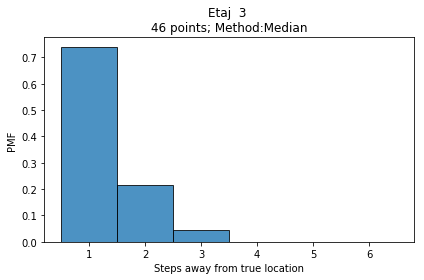

Percentages:  [0.73913043 0.2173913  0.04347826 0.         0.         0.        ]


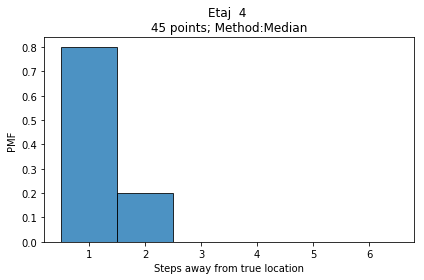

Percentages:  [0.8 0.2 0.  0.  0.  0. ]


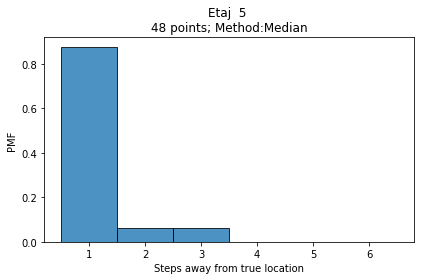

Percentages:  [0.875  0.0625 0.0625 0.     0.     0.    ]


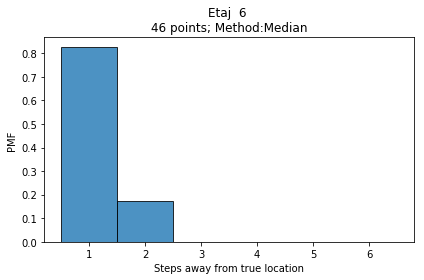

Percentages:  [0.82608696 0.17391304 0.         0.         0.         0.        ]


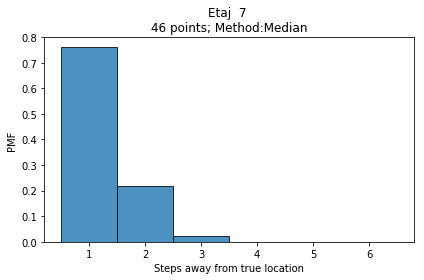

Percentages:  [0.76086957 0.2173913  0.02173913 0.         0.         0.        ]


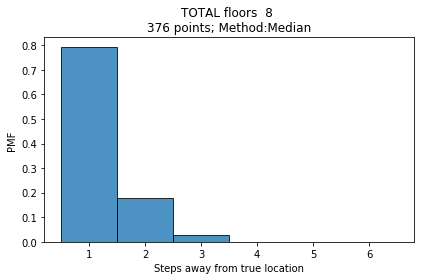

Percentages:  [0.79255319 0.17819149 0.02925532 0.         0.         0.        ]


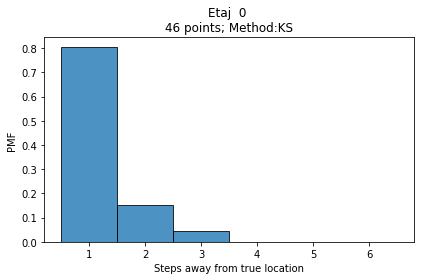

Percentages:  [0.80434783 0.15217391 0.04347826 0.         0.         0.        ]


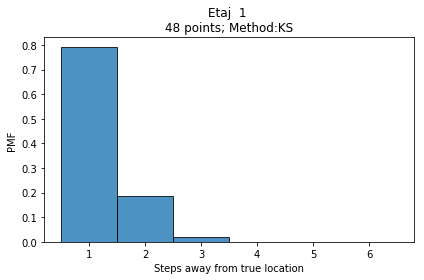

Percentages:  [0.79166667 0.1875     0.02083333 0.         0.         0.        ]


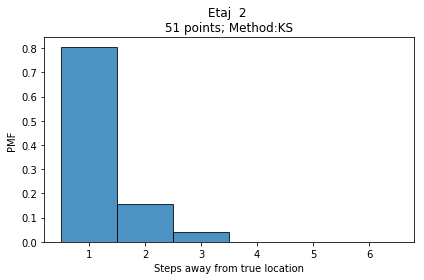

Percentages:  [0.80392157 0.15686275 0.03921569 0.         0.         0.        ]


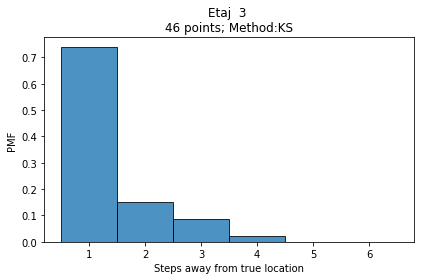

Percentages:  [0.73913043 0.15217391 0.08695652 0.02173913 0.         0.        ]


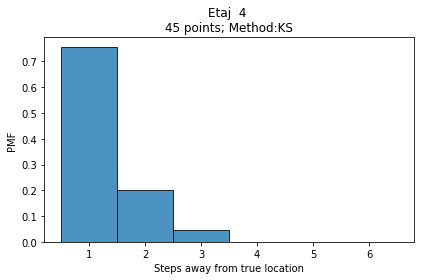

Percentages:  [0.75555556 0.2        0.04444444 0.         0.         0.        ]


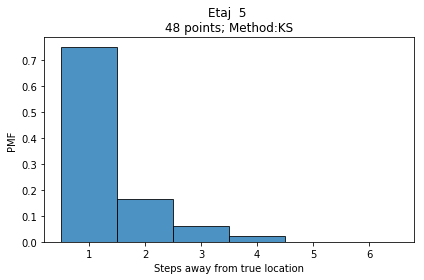

Percentages:  [0.75       0.16666667 0.0625     0.02083333 0.         0.        ]


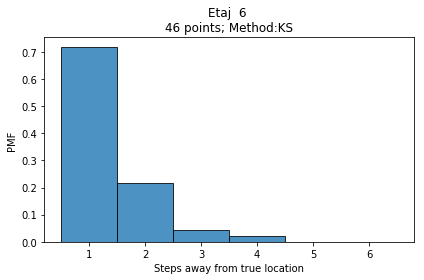

Percentages:  [0.7173913  0.2173913  0.04347826 0.02173913 0.         0.        ]


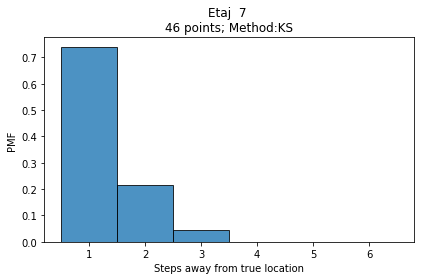

Percentages:  [0.73913043 0.2173913  0.04347826 0.         0.         0.        ]


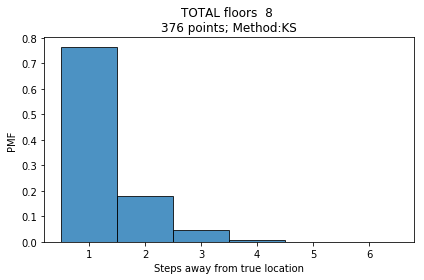

Percentages:  [0.76329787 0.18085106 0.04787234 0.00797872 0.         0.        ]


In [12]:
etaje = retaje
for method in ['Average', 'Bestdir', 'Median', 'KS']:
#for method in ['Max', 'Median', 'KS']:
    e = 0 
    total_nearest = []
    for etaj in etaje: 
        max_nearest = test_allvsall(etaj, method)
        total_nearest = total_nearest +  max_nearest
        
        nearest = np.array(max_nearest)
               
        away = nearest[:, 3] # steps away from true 
        b = np.arange(1, 8, 1) # Bins of histogram - from 1 to 5 
        bin_width = b[1] - b[0]

        hist_away, bins_out = np.histogram(away, b, density=False)

        hist_away = hist_away / away.size

        fig = plt.figure()
        plt.bar(b[:-1], hist_away, width=bin_width, ec='k', alpha=0.8)
        plt.xlabel("Steps away from true location")
        plt.ylabel("PMF")
        plt.title("{} {} \n{}{} Method:{}".format("Etaj ", e, len(nearest), " points;", method))
        e = e + 1
        plt.tight_layout()
        
        plt.show()
        print("Percentages: ", hist_away)
        
                
    away = np.array(total_nearest)[:, 3] # steps away from true 
    b = np.arange(1, 8, 1) # Bins of histogram - from 1 to 5 
    bin_width = b[1] - b[0]

    hist_away, bins_out = np.histogram(away, b, density=False)

    hist_away = hist_away / away.size

    fig = plt.figure()
    plt.bar(b[:-1], hist_away, width=bin_width, ec='k', alpha=0.8)
    plt.xlabel("Steps away from true location")
    plt.ylabel("PMF")
    plt.title("{} {} \n{}{} Method:{}".format("TOTAL floors ", len(etaje), len(total_nearest), " points;", method))
    e = e + 1
    plt.tight_layout()

    plt.show()
    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
    print("Percentages: ", hist_away)
        

In [5]:
good_pts = nearest[away == 1]
dists = good_pts[:, 2] # steps away from true 
b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]

hist_away, bins_out = np.histogram(dists, b, density=False)

hist_away = hist_away / away.size

fig = plt.figure()
plt.bar(b[:-1], hist_away, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Steps away from true location")
plt.ylabel("PMF")
plt.title("{}\n{}{}".format("Distribution of distances across ", len(dists), " good points (closest is 1 step away)"))

plt.tight_layout()
#fig.savefig(os.path.join(save_img_dir, fn))
plt.show()
print("Mean Std =", np.mean(dists), np.std(dists))

NameError: name 'nearest' is not defined

<Figure size 432x288 with 0 Axes>

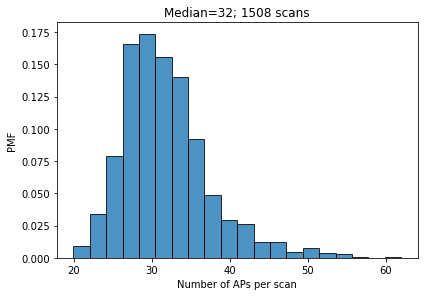

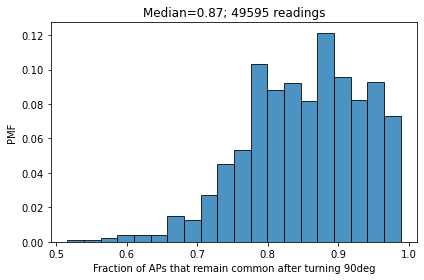

<Figure size 432x288 with 0 Axes>

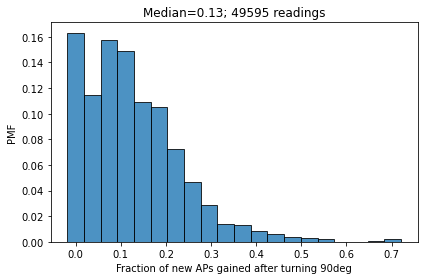

<Figure size 432x288 with 0 Axes>

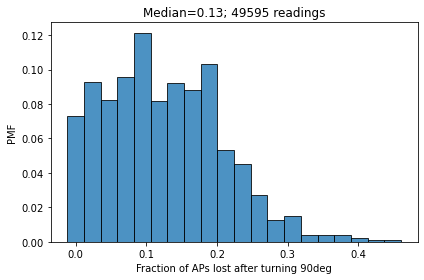

<Figure size 432x288 with 0 Axes>

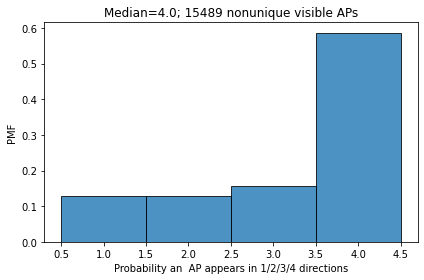

<Figure size 432x288 with 0 Axes>

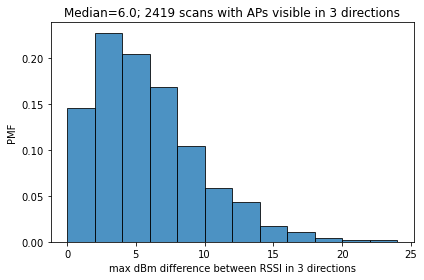

<Figure size 432x288 with 0 Axes>

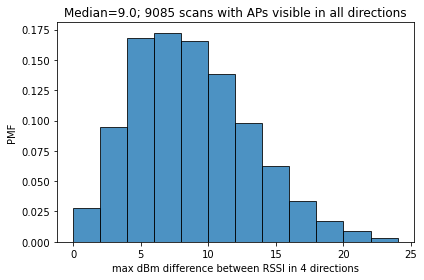

In [183]:
"""
Statistics about measuement in 4 cardinal directions:

- we need to measure in several directions 
- at a location, only 60% of APs appear in all 4 directions 
- when turing 90deg, 87% of APs remain common, 13% are lost, 13% are gained 
- when reading in three directions, 50% of RSSI changes more than 6dBm, and 10% changes more than ~10dBm
- when reading in three directions, 50% of RSSI changes more than 9dBm, and 10% changes more than ~15dBm
"""


#f = merge_wifi_fingerprints(etaje[0][2]['fingerprints'])
#print(f)
APstats = {'total':[], 'common':[], 'lost':[], 'gained':[], 'ndirs':[], 'dbmdiff2':[], 'dbmdiff4':[]}
for e in etaje: 
    for c in e:
        f = c['fingerprints']
        allf = merge_wifi_fingerprints(f)['wifi']
        for mac in allf:
            APstats['ndirs'].append(len(allf[mac]['rssi'])) # number of directions an AP is visible
            if len(allf[mac]['rssi'])==3:
                APstats['dbmdiff2'].append(max(allf[mac]['rssi']) - min(allf[mac]['rssi'])) # max dBm difference 
            if len(allf[mac]['rssi'])==4:    
                APstats['dbmdiff4'].append(max(allf[mac]['rssi']) - min(allf[mac]['rssi'])) # max dBm difference 

        for d in range(0,4): # for harvesting N/E/S/W directions without preproc
            m0 = set(f[d]['wifi'].keys())
            m1 = set(f[(d+1) % 4]['wifi'].keys())
            #print(len(m0), len(m0 & m1)/len(m0), len(m0 - m1)/len(m0), len(m1 - m0)/len(m0))  
            APstats['total'].append(len(m0))              # totalAPs
            APstats['common'].append(len(m0 & m1)/len(m0)) # fraction of APs common  
            APstats['lost'].append(len(m0 - m1)/len(m0))   # lost APs
            APstats['gained'].append(len(m1 - m0)/len(m0)) # gained APs

#for stat in APstats.keys():            
#    a = np.array(APstats[stat])
    #b = np.arange(1, 50, 1) # Bins of histogram - from 1 to 5 
stat='total'    
a = np.array(APstats[stat])
f = plt.figure()
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Number of APs per scan')
plt.ylabel("PMF")
plt.tight_layout()
plt.title(f"Median={np.median(APstats[stat]):.0f}; {len(APstats[stat])} scans")
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')

stat='common'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Fraction of APs that remain common after turning 90deg')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat]):.2f}; {sum(APstats['total'])} readings")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')

stat='gained'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Fraction of new APs gained after turning 90deg')
plt.title(f"Median={np.median(APstats[stat]):.2f}; {sum(APstats['total'])} readings")
plt.ylabel("PMF")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')


stat='lost'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=20, density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Fraction of APs lost after turning 90deg')
plt.title(f"Median={np.median(APstats[stat]):.2f}; {sum(APstats['total'])} readings")
plt.ylabel("PMF")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')

stat='ndirs'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=[1,2,3,4,5], density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('Probability an  AP appears in 1/2/3/4 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} nonunique visible APs")
plt.tight_layout()
plt.show()
fig.savefig(f"{stat}.pdf", bbox_inches='tight')


stat='dbmdiff2'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=np.arange(1,26,2), density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('max dBm difference between RSSI in 3 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} scans with APs visible in 3 directions")
plt.tight_layout()
plt.show()
fig.savefig("max_dbm_diff_3dir.pdf", bbox_inches='tight')

stat='dbmdiff4'    
fig = plt.figure()
a = np.array(APstats[stat])
hist_bars, bins_out = np.histogram(APstats[stat], bins=np.arange(1,26,2), density=False)
bin_width = bins_out[1] - bins_out[0]
hist_bars = hist_bars / len(APstats[stat])
fig = plt.figure()
plt.bar(bins_out[:-1], hist_bars, width=bin_width, ec='k', alpha=0.8)
plt.xlabel('max dBm difference between RSSI in 4 directions')
plt.ylabel("PMF")
plt.title(f"Median={np.median(APstats[stat])}; {len(APstats[stat])} scans with APs visible in all directions")
plt.tight_layout()
plt.show()
fig.savefig("max_dbm_diff_4dir.pdf", bbox_inches='tight')



#for mac  in etaje[0][2]['fingerprints'][3]['wifi']:
#    print(mac, etaje[0][2]['fingerprints'][3]['wifi'][mac]['rssi'])



In [149]:


print("\n22=", merge_wifi_fingerprints(etaje[6][22]['fingerprints'])['wifi'])
w = merge_wifi_fingerprints(etaje[6][22]['fingerprints'])['wifi']
for mac in w:
    print(len(w[mac]['rssi']))

print("\n23=", merge_wifi_fingerprints(etaje[6][23]['fingerprints'])['wifi'])

print("\n24=", merge_wifi_fingerprints(etaje[6][24]['fingerprints'])['wifi'])

print("22-23 ", compare_locations(etaje[6][22], etaje[6][23], braycurtis, 'Bestdir'))
print("22-24 ", compare_locations(etaje[6][22], etaje[6][22], braycurtis, 'Bestdir'))




22= {'84:b2:61:6d:52:af': {'ssid': 'eduroam', 'frequency': '5180', 'rssi': [-42, -41, -40, -39]}, '84:b2:61:6d:52:ae': {'ssid': 'UPB-Guest', 'frequency': '5180', 'rssi': [-42, -41, -39, -39]}, '84:b2:61:6d:52:ad': {'ssid': 'PRECIS', 'frequency': '5180', 'rssi': [-42, -40, -40, -39]}, '84:b2:61:6d:52:a2': {'ssid': 'PRECIS', 'frequency': '2412', 'rssi': [-48, -46, -43, -40]}, '84:b2:61:6d:52:a1': {'ssid': 'UPB-Guest', 'frequency': '2412', 'rssi': [-48, -46, -43]}, '84:b2:61:6d:5d:7f': {'ssid': 'eduroam', 'frequency': '5220', 'rssi': [-75, -74, -71, -67]}, '84:b2:61:6d:52:a0': {'ssid': 'eduroam', 'frequency': '2412', 'rssi': [-48, -46, -43, -39]}, '84:b2:61:6d:5d:7e': {'ssid': 'UPB-Guest', 'frequency': '5220', 'rssi': [-75, -75, -71, -68]}, '84:b2:61:6d:5d:7d': {'ssid': 'PRECIS', 'frequency': '5220', 'rssi': [-75, -74, -71, -68]}, '84:b2:61:47:e2:cf': {'ssid': 'eduroam', 'frequency': '5280', 'rssi': [-59, -54, -50, -50]}, '84:b2:61:47:e2:ce': {'ssid': 'UPB-Guest', 'frequency': '5280', 'r